In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

import pandas as pd
import yfinance as yf
from yahoofinancials import YahooFinancials
from datetime import datetime, timedelta
from tqdm import tqdm
from time import time
from sklearn.linear_model import LinearRegression


# TASK 1

In [6]:
def cont_comp_returns(sol):
    return np.diff(sol) / sol[:-1]


def year_return(stocks, weights, periods):
    return (1+np.sum((stocks.mean() * weights)))**periods - 1


def year_std(stocks, weights, periods):
    return np.sqrt(np.dot(weights.T, np.dot(stocks.cov(), weights))) * np.sqrt(periods)


In [3]:
yahoo_financials1 = YahooFinancials('AAPL')
data1 = yahoo_financials1.get_historical_price_data(start_date='2010-01-01',
                                                    end_date='2021-12-31',
                                                    time_interval='weekly')
comp_df = pd.DataFrame(data1['AAPL']['prices'])
aapl = cont_comp_returns(comp_df['close']).dropna()

yahoo_financials2 = YahooFinancials('PG')
data2 = yahoo_financials2.get_historical_price_data(start_date='2010-01-01',
                                                    end_date='2021-12-31',
                                                    time_interval='weekly')
comp_df = pd.DataFrame(data2['PG']['prices'])
pg = cont_comp_returns(comp_df['close']).dropna()

yahoo_financials2 = YahooFinancials('TSLA')
data2 = yahoo_financials2.get_historical_price_data(start_date='2010-01-01',
                                                    end_date='2021-12-31',
                                                    time_interval='weekly')
comp_df = pd.DataFrame(data2['TSLA']['prices'])
tsla = cont_comp_returns(comp_df['close']).dropna()

yahoo_financials2 = YahooFinancials('VGT')
data2 = yahoo_financials2.get_historical_price_data(start_date='2010-01-01',
                                                    end_date='2021-12-31',
                                                    time_interval='weekly')
comp_df = pd.DataFrame(data2['VGT']['prices'])
vgt = cont_comp_returns(comp_df['close']).dropna()

yahoo_financials2 = YahooFinancials('BNDX')
data2 = yahoo_financials2.get_historical_price_data(start_date='2010-01-01',
                                                    end_date='2021-12-31',
                                                    time_interval='weekly')
comp_df = pd.DataFrame(data2['BNDX']['prices'])
bndx = cont_comp_returns(comp_df['close']).dropna()

yahoo_financials2 = YahooFinancials('AMZN')
data2 = yahoo_financials2.get_historical_price_data(start_date='2010-01-01',
                                                    end_date='2021-12-31',
                                                    time_interval='weekly')
comp_df = pd.DataFrame(data2['AMZN']['prices'])
amzn = cont_comp_returns(comp_df['close']).dropna()


## (a) Чтобы доказать следующие соотношения сгенерируем портфель, посчитаем левые и правые части.

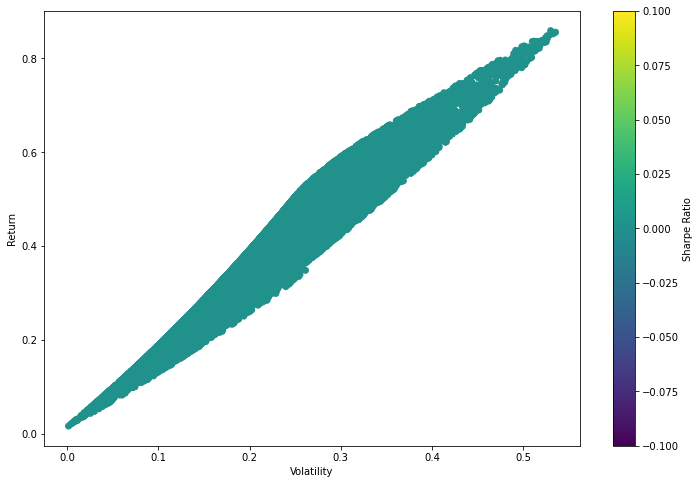

AAPL_ret    0.005454
PG_ret      0.011933
dtype: float64 [0.00642619        nan]
AAPL_ret   -0.000972
PG_ret           NaN
dtype: float64 res


In [5]:
rs_rate = 0.015
stocks = pd.DataFrame()
stocks['AAPL_ret'] = aapl
stocks['PG_ret'] = tsla
stocks['Risk_free'] = np.ones(stocks.shape[0]) * \
    np.power(1 + rs_rate, 1/52) - 1


np.random.seed(42)
num_ports = 28000
risk_aversion = 20
all_weights = np.zeros((num_ports, len(stocks.columns)))
ret_arr = np.zeros(num_ports)
std_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)


for x in range(num_ports):
    # Weights
    weights = np.array(np.random.random(3))
    weights = weights/np.sum(weights)

    # Save weights
    all_weights[x, :] = weights

    # Expected return
    ret_arr[x] = (1+np.sum((stocks.mean() * weights)))**52 - 1

    # Expected volatility
    std_arr[x] = np.sqrt(np.dot(weights.T, np.dot(
        stocks.cov(), weights))) * np.sqrt(52)

U = (ret_arr - (risk_aversion/2) * np.square(std_arr))

opt_solution, opt_solution_idx = np.max(U), np.argmax(U)
opt_weights = all_weights[opt_solution_idx]
opt_returns = (stocks * opt_weights).sum(axis=1)
stocks['Optimal'] = opt_returns


plt.figure(figsize=(12, 8))
plt.scatter(std_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.show()


left_part = stocks[['AAPL_ret', 'PG_ret']].mean() - stocks['Risk_free'].mean()
right_part = (risk_aversion * np.cov(stocks.T)[[0, 1], -1])
res = left_part - right_part
print(left_part, right_part)
print(res, 'res')


## Так как разность левой и правой части получилось очень маленькой, то тождество доказано.

## (b)

In [148]:
examples = 10

diff = []
portfolios_idx = np.flip(np.argsort(U))[:examples]
chosen_weights = all_weights[portfolios_idx]
for weights in chosen_weights:
    Rf = stocks['Risk_free'].mean()
    Rp = np.expand_dims(
        (stocks[['AAPL_ret', 'PG_ret', 'Risk_free']] * weights).sum(axis=1).to_numpy(), axis=1)
    Rp_mean = Rp.mean()
    Rp_var = Rp.var(ddof=0)

    Ri_returns = stocks[['AAPL_ret', 'PG_ret']].to_numpy()
    Ri_mean = Ri_returns.mean()
    left_part = Ri_mean - Rf

    cov_inp = np.hstack((Ri_returns, Rp))
    cov = np.cov(np.hstack((Ri_returns, Rp)).T)[:-1, -1]
    print(cov.shape)
    beta = cov/Rp_var
    right_part = beta * (Rp_mean - Rf)
    diff_value = left_part - right_part
    diff.append(diff_value)

diff


(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)


[array([-0.00198438,  0.00198822]),
 array([-0.0019757 ,  0.00196683]),
 array([-0.0019675 ,  0.00194801]),
 array([-0.00199533,  0.00201786]),
 array([-0.00198912,  0.00200063]),
 array([-0.00197878,  0.00197424]),
 array([-0.00196868,  0.00195065]),
 array([-0.00194165,  0.00189526]),
 array([-0.00197486,  0.00196486]),
 array([-0.00193831,  0.00188903])]

## Аналогично получили маленькие разности левых и правых частей

## (c)

In [9]:
def Linreg_company(ticker, num_samples, stocks, U):
    Ri = stocks[ticker].to_numpy()
    Rf = stocks['Risk_free'][0]
    portfolios_idx = np.flip(np.argsort(U))[:num_samples]
    chosen_weights = all_weights[portfolios_idx]

    beta1_lr_arr = []
    beta1_analytic_arr = []
    beta0_lr_arr = []
    error_mean_arr = []
    error_cov_arr = []

    for weights in chosen_weights:
        Rp = np.expand_dims(
            (stocks[['AAPL_ret', 'PG_ret', 'Risk_free']] * weights).sum(axis=1).to_numpy(), axis=1)

        # Calculate regression coeffs
        reg_apl = LinearRegression().fit((Rp - Rf), Ri)
        beta1_lr = reg_apl.coef_[0]
        beta0_lr = reg_apl.intercept_
        beta0_lr_arr.append(beta0_lr)
        beta1_lr_arr.append(beta1_lr)

        # Calculate error and beta1
        Ri_pred = beta0_lr + beta1_lr * (Rp - Rf)
        error = (Rp - Ri_pred).squeeze()
        error_mean = np.mean(error)
        error_cov = np.cov(Rp.squeeze(), error)[0][1]
        error_mean_arr.append(error_mean)
        error_cov_arr.append(error_cov)

        beta1_anal = np.cov(Ri, Rp.squeeze())[0][1] / (Rp.squeeze() - Rf).var()
        beta1_analytic_arr.append(beta1_anal)

    beta0_diff = np.mean(beta0_lr_arr) - Rf
    beta1_diff = np.mean(beta1_lr_arr) - np.mean(beta1_analytic_arr)
    error_mean_fin = np.mean(error_mean_arr)
    error_cov_fin = np.mean(error_cov_arr)

    return beta0_diff, beta1_diff, error_mean_fin, error_cov_fin


a, b, c, d = Linreg_company('AAPL_ret', 10, stocks, U)
print(a, b, c, d)


2.556706864840282e-06 -0.006834873288692478 -0.004175179402238648 -0.00022654854518523623


## (d)

In [13]:
num_samples = 10
portfolios_idx = np.flip(np.argsort(U))[:num_samples]
chosen_weights = all_weights[portfolios_idx]

Rf = stocks['Risk_free'][0]
SR = []
for weights in chosen_weights:
    Rp = (stocks[['AAPL_ret', 'PG_ret', 'Risk_free']]
          * weights).sum(axis=1).to_numpy()
    Rp_mean = Rp.mean()
    Rp_std = Rp.std()
    sr = (Rp_mean - Rf) / Rp_std
    SR.append(sr)

print(np.mean(SR), np.std(SR))


0.0015778701883338727 0.008408065844988696
0.0015829965421685196 0.00844112134376686
0.0015396746309848295 0.008159195816048334
0.0015346385111560607 0.008127763440417447
0.001595202425528648 0.008521301099867984
0.0015216561651948005 0.008041850008718678
0.0016033209962702465 0.008573502533542903
0.00158952963205594 0.00848604840313196
0.0015146917124105167 0.007996450051007329
0.0015952414677283403 0.008523716827526033
0.15359489767467363 1.849261960314837e-05


# TASK 2

In [7]:
tickers = ['AXP', 'BA', 'CAT', 'CVX', 'DIS', 'IBM', 'INTC', 'JNJ', 'JPM', 'KO',
           'MCD', 'MMM', 'MRK', 'PFE', 'PG', 'TRV', 'RTX', 'WBA', 'WMT', 'XOM']
rs_rate = 0.015
df = pd.DataFrame()

for ticker in tickers:
    yahoo_financials = YahooFinancials(ticker)
    yahoo_data = yahoo_financials.get_historical_price_data(start_date='1978-01-01',
                                                            end_date='2021-12-31',
                                                            time_interval='monthly')
    temp_df = pd.DataFrame(yahoo_data[ticker]['prices'])

    df[ticker] = cont_comp_returns(temp_df['close'])
df['Risk_free'] = np.ones(df.shape[0]) * np.power(1 + rs_rate/12, 1/12) - 1
df.to_csv('tickers_close_prices.csv')
df

,AXP,BA,CAT,CVX,DIS,IBM,INTC,JNJ,JPM,KO,...,MMM,MRK,PFE,PG,TRV,RTX,WBA,WMT,XOM,Risk_free
0,-0.002915,0.050100,-0.014981,0.010949,0.047059,-0.053672,-0.089431,0.009616,0.050000,0.058334,...,-0.028148,0.040365,0.018987,0.011111,0.068396,-0.023323,0.078680,0.000000,-0.010417,0.000104
1,-0.032164,-0.045802,-0.030418,0.007220,0.011237,-0.062687,-0.008928,0.066666,-0.047619,0.102362,...,0.003049,0.050063,0.065217,-0.024176,0.086093,-0.023881,0.021177,-0.019231,0.057895,0.000104
2,0.042296,-0.034000,-0.007843,0.064516,-0.026985,0.129512,-0.009008,0.044643,0.010000,-0.021429,...,-0.063830,-0.029798,0.037901,-0.060811,0.079268,-0.067278,-0.078341,0.050421,0.024876,0.000104
3,0.066667,0.101449,0.094862,-0.037037,0.135400,-0.029135,-0.040910,0.071225,0.092409,-0.009124,...,-0.025974,0.060197,0.123596,0.033573,0.047081,0.147541,0.150000,0.117333,0.048544,0.000104
4,0.032609,0.009398,-0.043321,0.045455,0.079023,-0.003872,-0.014217,-0.013298,-0.003021,0.022099,...,0.040000,0.044032,-0.010000,0.041763,0.043165,-0.051429,-0.039130,0.042959,-0.002315,0.000104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438,-0.026799,-0.030819,0.019927,-0.049504,0.029997,0.003287,0.006329,0.005401,0.053828,-0.012625,...,-0.016166,-0.007545,0.076150,0.001125,0.072455,-0.025187,0.076352,0.038934,-0.052979,0.000104
439,0.009460,0.002005,-0.089629,0.048362,-0.066906,-0.012844,-0.014428,-0.067175,0.023382,-0.068194,...,-0.099209,-0.015467,-0.066421,-0.018189,-0.048212,0.014158,-0.072906,-0.058879,0.078870,0.000104
440,0.037307,-0.058698,0.062718,0.128536,-0.000591,-0.133962,-0.080330,0.008545,0.037876,0.074328,...,0.018584,0.172281,0.016973,0.022818,0.058351,0.033737,-0.000638,0.072033,0.096056,0.000104
441,-0.123605,-0.044341,-0.052252,-0.014150,-0.142959,-0.013564,0.004082,-0.042670,-0.065101,-0.069541,...,-0.048355,-0.149233,0.228395,0.011120,-0.086586,-0.089354,-0.047214,-0.058827,-0.071816,0.000104


In [8]:
df = pd.read_csv('tickers_close_prices.csv')

In [238]:
def calc_weights(window, strategy, rf, ra, num_assets):
    if strategy == 'TAN':
        return TAN(window, rf, ra)
    elif strategy == 'GMV':
        return GMV(window, rf, num_assets)
    elif strategy == 'RP':
        return RP(window)
    elif strategy == 'EW':
        return EW(num_assets)


def run_strategy(strategy, stocks, rf=0.015, ra=10):
    start = 12 * 10
    end = len(stocks)
    profits = []
    final_profit = 1
    for t in tqdm(np.arange(start, end, 1)):

        stat_window = stocks.iloc[t - start: t, :]
        weights = calc_weights(stat_window, strategy, rf, ra, 21)
        month_return = (stocks.iloc[t, :] * weights).sum()
        final_profit = final_profit * (1 + month_return)
        profits.append(month_return)
    return profits, final_profit


def TAN(window, rf, ra):

    mu = window.iloc[:, :20].mean()
    cov1 = np.cov(window.iloc[:, :20].T)
    R0 = np.ones(20) * rf
    wtan = np.linalg.inv(cov1) @ (mu - R0)
    wtan = np.where(wtan > 0, wtan, 0)
    C = wtan.sum()
    wtan = wtan/C
    wa = (C/ra) * wtan
    w0 = 1 - C/ra
    wa = np.append(wa, w0)
    wa = np.where(wa > 0, wa, 0)
    wa = wa/wa.sum()
    return wa


def EW(num_assets):
    return 1/num_assets * np.ones(num_assets)


def GMV(window, rf, num_assets):
    np.random.seed(42)
    num_ports = 1500
    all_weights = np.zeros((num_ports, num_assets + 1))
    ret_arr = np.zeros(num_ports)
    std_arr = np.zeros(num_ports)

    for x in range(num_ports):
    # Weights
        weights = np.array(np.random.random(num_assets + 1))
        weights = weights/np.sum(weights)
    # Save weights
        all_weights[x, :] = weights
    # Expected return
        ret_arr[x] = (window.mean() * weights).sum()
    # Expected volatility
        std_arr[x] = (np.dot(weights.T, np.dot(window.cov(), weights)))

    gmv_weights_idx = std_arr.argmin()
    gmv_weights = all_weights[gmv_weights_idx]

    return gmv_weights


def RP(window):
    std_arr = window.iloc[:, :20].std()
    weights = (np.ones(20) / std_arr)
    weights = weights / weights.sum()
    weights = np.append(weights, 0)
    return weights


In [242]:
profits, final_profit  = run_strategy('TAN', df, 0.015, 5)
print(final_profit)


100%|██████████| 323/323 [00:00<00:00, 443.09it/s]

11.22676845849011


In [243]:
profits, final_profit  = run_strategy('GMV', df, 0.015, 5)
print(final_profit)

  0%|          | 0/323 [00:00<?, ?it/s]


ValueError: operands could not be broadcast together with shapes (21,) (22,) 

In [244]:
profits, final_profit  = run_strategy('RP', df, 0.015, 5)
print(final_profit)

100%|██████████| 323/323 [00:00<00:00, 780.10it/s]

14.433390544501837


In [245]:
profits, final_profit  = run_strategy('EW', df, 0.015, 5)
print(final_profit)

100%|██████████| 323/323 [00:00<00:00, 3225.45it/s]

14.254218895571565


In [241]:
x = np.linspace(0.5, 30, 50)
y = []
for i in x:
    profit,final_profit = run_strategy('TAN', df, 0.015, i)
    y.append(b)

plt.plot(x, y)

 22%|██▏       | 70/323 [00:00<00:00, 431.15it/s]


KeyboardInterrupt: 

In [220]:
y

[-1312260606684.9456,
 -5.52722840435062e-07,
 0.01297732521868547,
 2.202833955217745,
 6.577942436380618,
 62.81141372785179,
 100.76843926362672,
 104.43746981448021,
 92.45170833536339,
 77.16306090091726,
 63.251844602377744,
 51.84698710214036,
 42.83747443557978,
 35.792278641075725,
 30.274292885786096,
 25.921373809454636,
 22.454043933364694,
 19.66277270211527,
 17.39017227119904,
 15.520299275544057,
 13.966502582449564,
 12.662951076818171,
 11.559888832553934,
 10.61875626909191,
 9.80969159901574,
 9.108784573359682,
 8.49729247364028,
 7.960322077256528,
 7.486087994119304,
 7.06495181920472,
 6.689054070557062,
 6.35204069275935,
 6.04864970926346,
 5.774377249580888,
 5.525487975404143,
 5.298872266672151,
 5.0918101882851765,
 4.902023369718388,
 4.727566639889737,
 4.566763801268627,
 4.418164211322243,
 4.2805072901824195,
 4.152693353502657,
 4.033759521627915,
 3.922859725035766,
 3.8192480325236056,
 3.7222646882188335,
 3.631324367554428,
 3.545906259335808,
 3